<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [4]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [5]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [6]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
64504,2015-08-17 22:45:00,0.085938,0.000000,0.089844,0.265625,1.937500
64505,2015-08-17 23:00:00,0.128906,0.000000,0.140625,0.265625,1.750000
64506,2015-08-17 23:15:00,0.082031,0.000000,0.093750,0.265625,1.843750
64507,2015-08-17 23:30:00,0.144531,0.000000,0.156250,0.265625,1.687500


<h4>将一二层数据相加</h4>

In [7]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [8]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [9]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [10]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [11]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [12]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-17 19:00:00,8.187500,1.015625,1.187500,10.390625
2015-08-17 20:00:00,8.031250,1.000000,0.937500,9.968750
2015-08-17 21:00:00,8.656250,1.007812,1.046875,10.710938
2015-08-17 22:00:00,7.468750,0.949219,1.156250,9.574219


<AxesSubplot:>

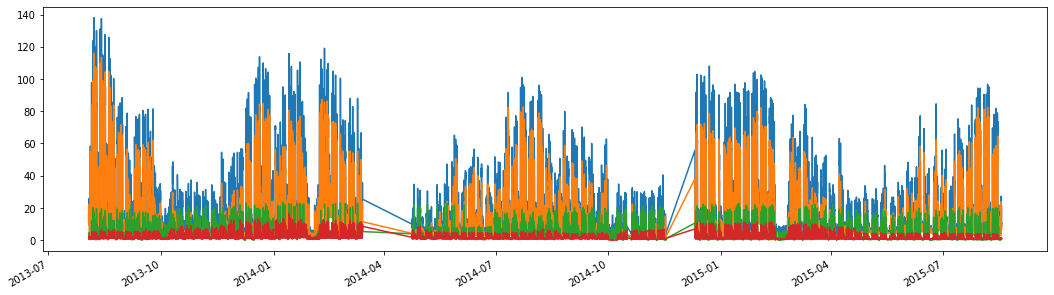

In [13]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [14]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [15]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [16]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["date"] = list(map(lambda x: x.date(), data.index.to_list()))
data["wind_angle"] = data["wind_angle"].apply(lambda x: np.cos(np.pi / 180 * x))
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)

mean_weather = data[["date", "temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]].groupby("date").mean()
sum_weather = data[["date", "rainfall"]].groupby("date").sum()
data = pd.merge(data.drop(columns=["temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]), mean_weather, how="inner", left_on="date", right_index=True)
data = pd.merge(data.drop(columns=["rainfall"]), sum_weather, how="inner", left_on="date", right_index=True)
data = data.drop(columns=["date"])

# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,wind_direction,workday,hour,week,day,month,year,is_summer,is_winter,temp,humidity,atmos,wind_angle,wind_speed,cloud,rainfall
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,东南风,0,0,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,东南风,0,1,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,东南风,0,2,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,东南风,0,3,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,东南风,0,4,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,东北风,1,19,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,东北风,1,20,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,东北风,1,21,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [17]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,workday,hour,week,day,month,year,...,cloud,rainfall,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [18]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,workday,hour,day,month,year,is_summer,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [19]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [20]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [21]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [22]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [23]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [24]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

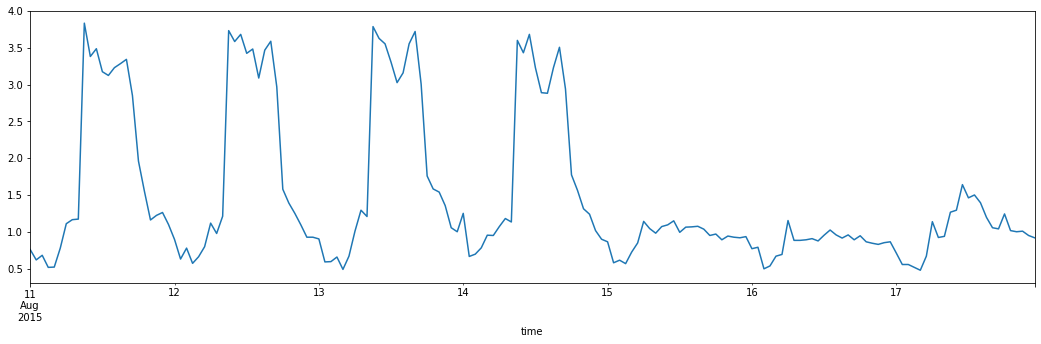

In [25]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [26]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [27]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [28]:
socket_pred2 = data_socket.loc[: "2015-08-17 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [29]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063462
0:	learn: 1.9021190	total: 56ms	remaining: 56s
1:	learn: 1.8126397	total: 58.4ms	remaining: 29.1s
2:	learn: 1.7295371	total: 60.7ms	remaining: 20.2s
3:	learn: 1.6531055	total: 63ms	remaining: 15.7s
4:	learn: 1.5829596	total: 65.3ms	remaining: 13s
5:	learn: 1.5172177	total: 67.6ms	remaining: 11.2s
6:	learn: 1.4583006	total: 69.8ms	remaining: 9.9s
7:	learn: 1.4022904	total: 71.8ms	remaining: 8.9s
8:	learn: 1.3519502	total: 73.9ms	remaining: 8.13s
9:	learn: 1.3051437	total: 75.8ms	remaining: 7.51s
10:	learn: 1.2625295	total: 77.9ms	remaining: 7s
11:	learn: 1.2236371	total: 79.9ms	remaining: 6.58s
12:	learn: 1.1882331	total: 81.9ms	remaining: 6.21s
13:	learn: 1.1562660	total: 83.9ms	remaining: 5.91s
14:	learn: 1.1265692	total: 86ms	remaining: 5.65s
15:	learn: 1.0996298	total: 88.2ms	remaining: 5.42s
16:	learn: 1.0749785	total: 90.1ms	remaining: 5.21s
17:	learn: 1.0521629	total: 92.3ms	remaining: 5.04s
18:	learn: 1.0322155	total: 94.4ms	remaining: 4.87s
19:	lea

245:	learn: 0.5608763	total: 534ms	remaining: 1.64s
246:	learn: 0.5604313	total: 536ms	remaining: 1.63s
247:	learn: 0.5599419	total: 538ms	remaining: 1.63s
248:	learn: 0.5593347	total: 540ms	remaining: 1.63s
249:	learn: 0.5589518	total: 542ms	remaining: 1.63s
250:	learn: 0.5583143	total: 544ms	remaining: 1.62s
251:	learn: 0.5576411	total: 546ms	remaining: 1.62s
252:	learn: 0.5571772	total: 548ms	remaining: 1.62s
253:	learn: 0.5568519	total: 550ms	remaining: 1.61s
254:	learn: 0.5565939	total: 552ms	remaining: 1.61s
255:	learn: 0.5562737	total: 554ms	remaining: 1.61s
256:	learn: 0.5558486	total: 556ms	remaining: 1.61s
257:	learn: 0.5551808	total: 558ms	remaining: 1.6s
258:	learn: 0.5546323	total: 560ms	remaining: 1.6s
259:	learn: 0.5542446	total: 561ms	remaining: 1.6s
260:	learn: 0.5538140	total: 563ms	remaining: 1.59s
261:	learn: 0.5535749	total: 565ms	remaining: 1.59s
262:	learn: 0.5531415	total: 567ms	remaining: 1.59s
263:	learn: 0.5526095	total: 569ms	remaining: 1.59s
264:	learn: 0.5

431:	learn: 0.4967608	total: 893ms	remaining: 1.17s
432:	learn: 0.4965132	total: 895ms	remaining: 1.17s
433:	learn: 0.4961423	total: 897ms	remaining: 1.17s
434:	learn: 0.4959395	total: 899ms	remaining: 1.17s
435:	learn: 0.4957520	total: 901ms	remaining: 1.17s
436:	learn: 0.4954732	total: 903ms	remaining: 1.16s
437:	learn: 0.4953328	total: 905ms	remaining: 1.16s
438:	learn: 0.4950516	total: 907ms	remaining: 1.16s
439:	learn: 0.4946409	total: 909ms	remaining: 1.16s
440:	learn: 0.4944624	total: 911ms	remaining: 1.15s
441:	learn: 0.4942608	total: 913ms	remaining: 1.15s
442:	learn: 0.4941010	total: 915ms	remaining: 1.15s
443:	learn: 0.4938566	total: 917ms	remaining: 1.15s
444:	learn: 0.4936720	total: 918ms	remaining: 1.15s
445:	learn: 0.4933542	total: 920ms	remaining: 1.14s
446:	learn: 0.4932078	total: 922ms	remaining: 1.14s
447:	learn: 0.4930328	total: 924ms	remaining: 1.14s
448:	learn: 0.4928815	total: 926ms	remaining: 1.14s
449:	learn: 0.4924852	total: 928ms	remaining: 1.13s
450:	learn: 

618:	learn: 0.4611770	total: 1.25s	remaining: 771ms
619:	learn: 0.4609772	total: 1.25s	remaining: 769ms
620:	learn: 0.4607465	total: 1.26s	remaining: 767ms
621:	learn: 0.4606695	total: 1.26s	remaining: 765ms
622:	learn: 0.4605247	total: 1.26s	remaining: 763ms
623:	learn: 0.4604421	total: 1.26s	remaining: 761ms
624:	learn: 0.4603091	total: 1.26s	remaining: 759ms
625:	learn: 0.4601395	total: 1.27s	remaining: 757ms
626:	learn: 0.4600433	total: 1.27s	remaining: 755ms
627:	learn: 0.4599195	total: 1.27s	remaining: 753ms
628:	learn: 0.4597430	total: 1.27s	remaining: 751ms
629:	learn: 0.4595015	total: 1.27s	remaining: 749ms
630:	learn: 0.4594009	total: 1.28s	remaining: 747ms
631:	learn: 0.4593103	total: 1.28s	remaining: 745ms
632:	learn: 0.4590644	total: 1.28s	remaining: 742ms
633:	learn: 0.4587136	total: 1.28s	remaining: 740ms
634:	learn: 0.4586480	total: 1.28s	remaining: 738ms
635:	learn: 0.4585124	total: 1.29s	remaining: 736ms
636:	learn: 0.4583548	total: 1.29s	remaining: 734ms
637:	learn: 

806:	learn: 0.4338350	total: 1.61s	remaining: 386ms
807:	learn: 0.4336419	total: 1.62s	remaining: 384ms
808:	learn: 0.4335012	total: 1.62s	remaining: 382ms
809:	learn: 0.4333655	total: 1.62s	remaining: 380ms
810:	learn: 0.4332663	total: 1.62s	remaining: 378ms
811:	learn: 0.4329976	total: 1.62s	remaining: 376ms
812:	learn: 0.4328503	total: 1.63s	remaining: 374ms
813:	learn: 0.4327652	total: 1.63s	remaining: 372ms
814:	learn: 0.4327109	total: 1.63s	remaining: 370ms
815:	learn: 0.4324500	total: 1.63s	remaining: 368ms
816:	learn: 0.4323360	total: 1.63s	remaining: 366ms
817:	learn: 0.4322151	total: 1.64s	remaining: 364ms
818:	learn: 0.4321537	total: 1.64s	remaining: 362ms
819:	learn: 0.4320641	total: 1.64s	remaining: 360ms
820:	learn: 0.4319400	total: 1.64s	remaining: 358ms
821:	learn: 0.4318214	total: 1.64s	remaining: 356ms
822:	learn: 0.4316587	total: 1.65s	remaining: 354ms
823:	learn: 0.4315814	total: 1.65s	remaining: 352ms
824:	learn: 0.4314647	total: 1.65s	remaining: 350ms
825:	learn: 

993:	learn: 0.4145342	total: 1.97s	remaining: 11.9ms
994:	learn: 0.4144348	total: 1.98s	remaining: 9.93ms
995:	learn: 0.4143438	total: 1.98s	remaining: 7.94ms
996:	learn: 0.4142691	total: 1.98s	remaining: 5.96ms
997:	learn: 0.4142032	total: 1.98s	remaining: 3.97ms
998:	learn: 0.4140974	total: 1.98s	remaining: 1.99ms
999:	learn: 0.4139499	total: 1.99s	remaining: 0us


<h5>构建xgboost</h5>

In [30]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [31]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [32]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:19:45,635 [INFO] loading LSTM model from ../models/LSTM_socket_final.h5


In [33]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

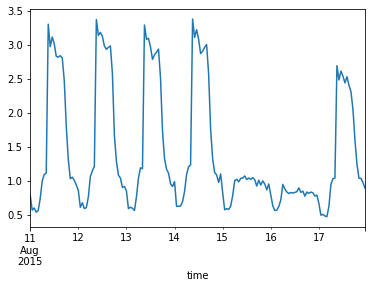

In [34]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4) / 4
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

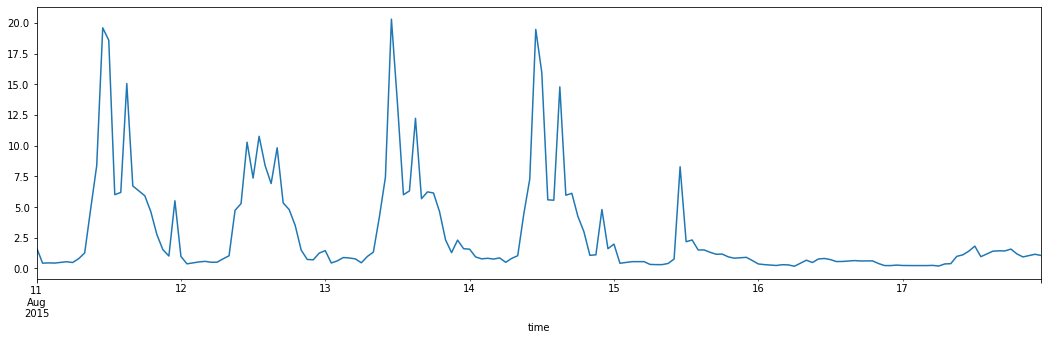

In [35]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [36]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [37]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [38]:
light_pred2 = data_light.loc[: "2015-08-17 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [39]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063462
0:	learn: 3.5540881	total: 2.43ms	remaining: 2.43s
1:	learn: 3.3893379	total: 13.2ms	remaining: 6.6s
2:	learn: 3.2378582	total: 15.7ms	remaining: 5.22s
3:	learn: 3.0988288	total: 18.1ms	remaining: 4.52s
4:	learn: 2.9714656	total: 20.5ms	remaining: 4.08s
5:	learn: 2.8552029	total: 22.7ms	remaining: 3.77s
6:	learn: 2.7462927	total: 25.1ms	remaining: 3.56s
7:	learn: 2.6491827	total: 27.3ms	remaining: 3.39s
8:	learn: 2.5585888	total: 29.7ms	remaining: 3.27s
9:	learn: 2.4750524	total: 32.1ms	remaining: 3.17s
10:	learn: 2.3994791	total: 34.4ms	remaining: 3.09s
11:	learn: 2.3320206	total: 36.7ms	remaining: 3.02s
12:	learn: 2.2687804	total: 38.9ms	remaining: 2.95s
13:	learn: 2.2078399	total: 41.1ms	remaining: 2.9s
14:	learn: 2.1514234	total: 43.4ms	remaining: 2.85s
15:	learn: 2.1065493	total: 45.6ms	remaining: 2.81s
16:	learn: 2.0580619	total: 47.9ms	remaining: 2.77s
17:	learn: 2.0164637	total: 50.1ms	remaining: 2.73s
18:	learn: 1.9787386	total: 52.4ms	remaining: 

167:	learn: 1.3565978	total: 347ms	remaining: 1.72s
168:	learn: 1.3557097	total: 349ms	remaining: 1.72s
169:	learn: 1.3543783	total: 351ms	remaining: 1.72s
170:	learn: 1.3527879	total: 353ms	remaining: 1.71s
171:	learn: 1.3516366	total: 355ms	remaining: 1.71s
172:	learn: 1.3502194	total: 357ms	remaining: 1.71s
173:	learn: 1.3496510	total: 359ms	remaining: 1.71s
174:	learn: 1.3486192	total: 361ms	remaining: 1.7s
175:	learn: 1.3479762	total: 363ms	remaining: 1.7s
176:	learn: 1.3471821	total: 365ms	remaining: 1.7s
177:	learn: 1.3453380	total: 367ms	remaining: 1.7s
178:	learn: 1.3444545	total: 369ms	remaining: 1.69s
179:	learn: 1.3433610	total: 371ms	remaining: 1.69s
180:	learn: 1.3421668	total: 373ms	remaining: 1.69s
181:	learn: 1.3406356	total: 375ms	remaining: 1.69s
182:	learn: 1.3398626	total: 377ms	remaining: 1.68s
183:	learn: 1.3390635	total: 379ms	remaining: 1.68s
184:	learn: 1.3382592	total: 381ms	remaining: 1.68s
185:	learn: 1.3374828	total: 383ms	remaining: 1.68s
186:	learn: 1.33

352:	learn: 1.2109026	total: 708ms	remaining: 1.3s
353:	learn: 1.2104681	total: 710ms	remaining: 1.3s
354:	learn: 1.2096021	total: 712ms	remaining: 1.29s
355:	learn: 1.2089868	total: 714ms	remaining: 1.29s
356:	learn: 1.2081382	total: 716ms	remaining: 1.29s
357:	learn: 1.2077026	total: 718ms	remaining: 1.29s
358:	learn: 1.2071768	total: 720ms	remaining: 1.29s
359:	learn: 1.2066787	total: 722ms	remaining: 1.28s
360:	learn: 1.2062125	total: 724ms	remaining: 1.28s
361:	learn: 1.2057119	total: 726ms	remaining: 1.28s
362:	learn: 1.2053082	total: 728ms	remaining: 1.28s
363:	learn: 1.2048835	total: 730ms	remaining: 1.28s
364:	learn: 1.2042859	total: 732ms	remaining: 1.27s
365:	learn: 1.2036310	total: 734ms	remaining: 1.27s
366:	learn: 1.2031592	total: 736ms	remaining: 1.27s
367:	learn: 1.2023379	total: 738ms	remaining: 1.27s
368:	learn: 1.2017816	total: 740ms	remaining: 1.26s
369:	learn: 1.2010935	total: 742ms	remaining: 1.26s
370:	learn: 1.2006388	total: 744ms	remaining: 1.26s
371:	learn: 1.

538:	learn: 1.1273567	total: 1.07s	remaining: 916ms
539:	learn: 1.1268193	total: 1.07s	remaining: 914ms
540:	learn: 1.1262721	total: 1.07s	remaining: 912ms
541:	learn: 1.1259575	total: 1.08s	remaining: 910ms
542:	learn: 1.1256339	total: 1.08s	remaining: 908ms
543:	learn: 1.1252651	total: 1.08s	remaining: 906ms
544:	learn: 1.1241226	total: 1.08s	remaining: 904ms
545:	learn: 1.1238842	total: 1.08s	remaining: 902ms
546:	learn: 1.1235264	total: 1.09s	remaining: 900ms
547:	learn: 1.1232680	total: 1.09s	remaining: 898ms
548:	learn: 1.1230034	total: 1.09s	remaining: 896ms
549:	learn: 1.1228011	total: 1.09s	remaining: 894ms
550:	learn: 1.1221860	total: 1.09s	remaining: 892ms
551:	learn: 1.1214825	total: 1.1s	remaining: 890ms
552:	learn: 1.1211678	total: 1.1s	remaining: 888ms
553:	learn: 1.1207582	total: 1.1s	remaining: 886ms
554:	learn: 1.1205168	total: 1.1s	remaining: 884ms
555:	learn: 1.1195646	total: 1.1s	remaining: 882ms
556:	learn: 1.1191252	total: 1.11s	remaining: 880ms
557:	learn: 1.118

723:	learn: 1.0587169	total: 1.43s	remaining: 546ms
724:	learn: 1.0584280	total: 1.43s	remaining: 544ms
725:	learn: 1.0581483	total: 1.43s	remaining: 542ms
726:	learn: 1.0579947	total: 1.44s	remaining: 540ms
727:	learn: 1.0577438	total: 1.44s	remaining: 538ms
728:	learn: 1.0574911	total: 1.44s	remaining: 536ms
729:	learn: 1.0573053	total: 1.44s	remaining: 534ms
730:	learn: 1.0569854	total: 1.44s	remaining: 532ms
731:	learn: 1.0566135	total: 1.45s	remaining: 530ms
732:	learn: 1.0564435	total: 1.45s	remaining: 528ms
733:	learn: 1.0560100	total: 1.45s	remaining: 526ms
734:	learn: 1.0556694	total: 1.45s	remaining: 524ms
735:	learn: 1.0552075	total: 1.45s	remaining: 522ms
736:	learn: 1.0548272	total: 1.46s	remaining: 520ms
737:	learn: 1.0544816	total: 1.46s	remaining: 518ms
738:	learn: 1.0542943	total: 1.46s	remaining: 516ms
739:	learn: 1.0540130	total: 1.46s	remaining: 514ms
740:	learn: 1.0535657	total: 1.46s	remaining: 512ms
741:	learn: 1.0533647	total: 1.47s	remaining: 510ms
742:	learn: 

908:	learn: 1.0071872	total: 1.79s	remaining: 179ms
909:	learn: 1.0068235	total: 1.79s	remaining: 178ms
910:	learn: 1.0064204	total: 1.8s	remaining: 176ms
911:	learn: 1.0062023	total: 1.8s	remaining: 174ms
912:	learn: 1.0059835	total: 1.8s	remaining: 172ms
913:	learn: 1.0058583	total: 1.8s	remaining: 170ms
914:	learn: 1.0056455	total: 1.8s	remaining: 168ms
915:	learn: 1.0054081	total: 1.81s	remaining: 166ms
916:	learn: 1.0051332	total: 1.81s	remaining: 164ms
917:	learn: 1.0050364	total: 1.81s	remaining: 162ms
918:	learn: 1.0047531	total: 1.81s	remaining: 160ms
919:	learn: 1.0046206	total: 1.81s	remaining: 158ms
920:	learn: 1.0043170	total: 1.82s	remaining: 156ms
921:	learn: 1.0040336	total: 1.82s	remaining: 154ms
922:	learn: 1.0036910	total: 1.82s	remaining: 152ms
923:	learn: 1.0035192	total: 1.82s	remaining: 150ms
924:	learn: 1.0033234	total: 1.82s	remaining: 148ms
925:	learn: 1.0028074	total: 1.83s	remaining: 146ms
926:	learn: 1.0026817	total: 1.83s	remaining: 144ms
927:	learn: 1.002

<h5>构建xgboost</h5>

In [40]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [41]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

In [42]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:19:52,934 [INFO] loading LSTM model from ../models/LSTM_light_final.h5


In [43]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

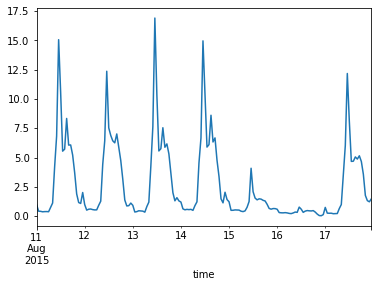

In [44]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4) / 4
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

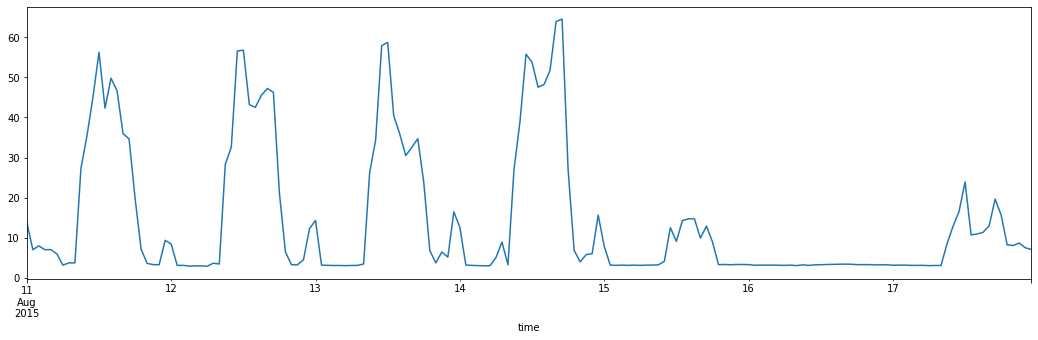

In [45]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [46]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [47]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [48]:
air_pred2 = data_air.loc[: "2015-08-17 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [49]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063462
0:	learn: 14.1219252	total: 2.94ms	remaining: 2.94s
1:	learn: 13.5629992	total: 5.54ms	remaining: 2.76s
2:	learn: 13.0535653	total: 7.98ms	remaining: 2.65s
3:	learn: 12.5761175	total: 10.5ms	remaining: 2.62s
4:	learn: 12.1192898	total: 12.9ms	remaining: 2.58s
5:	learn: 11.7115226	total: 15.2ms	remaining: 2.52s
6:	learn: 11.3453532	total: 17.6ms	remaining: 2.49s
7:	learn: 11.0140004	total: 19.9ms	remaining: 2.47s
8:	learn: 10.6898685	total: 22.1ms	remaining: 2.44s
9:	learn: 10.3979704	total: 24.6ms	remaining: 2.44s
10:	learn: 10.1300857	total: 27ms	remaining: 2.43s
11:	learn: 9.8844832	total: 29.4ms	remaining: 2.42s
12:	learn: 9.6610335	total: 31.7ms	remaining: 2.41s
13:	learn: 9.4508369	total: 34ms	remaining: 2.39s
14:	learn: 9.2570145	total: 36.3ms	remaining: 2.38s
15:	learn: 9.0886974	total: 38.6ms	remaining: 2.37s
16:	learn: 8.9277281	total: 41ms	remaining: 2.37s
17:	learn: 8.7845241	total: 43.4ms	remaining: 2.37s
18:	learn: 8.6553853	total: 45.8ms	rema

160:	learn: 5.2581994	total: 349ms	remaining: 1.82s
161:	learn: 5.2496560	total: 351ms	remaining: 1.82s
162:	learn: 5.2448700	total: 353ms	remaining: 1.81s
163:	learn: 5.2369183	total: 356ms	remaining: 1.81s
164:	learn: 5.2296344	total: 358ms	remaining: 1.81s
165:	learn: 5.2225434	total: 360ms	remaining: 1.81s
166:	learn: 5.2161037	total: 362ms	remaining: 1.81s
167:	learn: 5.2078253	total: 364ms	remaining: 1.8s
168:	learn: 5.2009720	total: 366ms	remaining: 1.8s
169:	learn: 5.1948162	total: 369ms	remaining: 1.8s
170:	learn: 5.1884364	total: 371ms	remaining: 1.8s
171:	learn: 5.1830285	total: 373ms	remaining: 1.79s
172:	learn: 5.1755317	total: 375ms	remaining: 1.79s
173:	learn: 5.1680977	total: 377ms	remaining: 1.79s
174:	learn: 5.1622114	total: 379ms	remaining: 1.79s
175:	learn: 5.1543891	total: 381ms	remaining: 1.78s
176:	learn: 5.1481445	total: 383ms	remaining: 1.78s
177:	learn: 5.1420197	total: 385ms	remaining: 1.78s
178:	learn: 5.1362343	total: 387ms	remaining: 1.77s
179:	learn: 5.12

337:	learn: 4.3302785	total: 713ms	remaining: 1.4s
338:	learn: 4.3282794	total: 715ms	remaining: 1.39s
339:	learn: 4.3243990	total: 717ms	remaining: 1.39s
340:	learn: 4.3200320	total: 719ms	remaining: 1.39s
341:	learn: 4.3172040	total: 721ms	remaining: 1.39s
342:	learn: 4.3141845	total: 723ms	remaining: 1.39s
343:	learn: 4.3109705	total: 726ms	remaining: 1.38s
344:	learn: 4.3070845	total: 728ms	remaining: 1.38s
345:	learn: 4.3019929	total: 730ms	remaining: 1.38s
346:	learn: 4.2982587	total: 732ms	remaining: 1.38s
347:	learn: 4.2949507	total: 735ms	remaining: 1.38s
348:	learn: 4.2916092	total: 737ms	remaining: 1.37s
349:	learn: 4.2865438	total: 739ms	remaining: 1.37s
350:	learn: 4.2834616	total: 741ms	remaining: 1.37s
351:	learn: 4.2784958	total: 743ms	remaining: 1.37s
352:	learn: 4.2749831	total: 745ms	remaining: 1.36s
353:	learn: 4.2708310	total: 747ms	remaining: 1.36s
354:	learn: 4.2666128	total: 749ms	remaining: 1.36s
355:	learn: 4.2634707	total: 751ms	remaining: 1.36s
356:	learn: 4

511:	learn: 3.8388447	total: 1.07s	remaining: 1.02s
512:	learn: 3.8370043	total: 1.08s	remaining: 1.02s
513:	learn: 3.8338508	total: 1.08s	remaining: 1.02s
514:	learn: 3.8318030	total: 1.08s	remaining: 1.02s
515:	learn: 3.8303758	total: 1.08s	remaining: 1.01s
516:	learn: 3.8291230	total: 1.08s	remaining: 1.01s
517:	learn: 3.8268822	total: 1.09s	remaining: 1.01s
518:	learn: 3.8248373	total: 1.09s	remaining: 1.01s
519:	learn: 3.8229594	total: 1.09s	remaining: 1.01s
520:	learn: 3.8215177	total: 1.09s	remaining: 1s
521:	learn: 3.8191604	total: 1.1s	remaining: 1s
522:	learn: 3.8173497	total: 1.1s	remaining: 1s
523:	learn: 3.8157086	total: 1.1s	remaining: 1000ms
524:	learn: 3.8141330	total: 1.1s	remaining: 997ms
525:	learn: 3.8122100	total: 1.1s	remaining: 995ms
526:	learn: 3.8103369	total: 1.11s	remaining: 993ms
527:	learn: 3.8079720	total: 1.11s	remaining: 991ms
528:	learn: 3.8066827	total: 1.11s	remaining: 989ms
529:	learn: 3.8053909	total: 1.11s	remaining: 987ms
530:	learn: 3.8031979	tot

687:	learn: 3.5215965	total: 1.44s	remaining: 651ms
688:	learn: 3.5192714	total: 1.44s	remaining: 649ms
689:	learn: 3.5182368	total: 1.44s	remaining: 647ms
690:	learn: 3.5163470	total: 1.44s	remaining: 645ms
691:	learn: 3.5151025	total: 1.44s	remaining: 643ms
692:	learn: 3.5139388	total: 1.45s	remaining: 641ms
693:	learn: 3.5122915	total: 1.45s	remaining: 639ms
694:	learn: 3.5109964	total: 1.45s	remaining: 637ms
695:	learn: 3.5097719	total: 1.45s	remaining: 635ms
696:	learn: 3.5084452	total: 1.46s	remaining: 633ms
697:	learn: 3.5072048	total: 1.46s	remaining: 630ms
698:	learn: 3.5058383	total: 1.46s	remaining: 628ms
699:	learn: 3.5044308	total: 1.46s	remaining: 626ms
700:	learn: 3.5023383	total: 1.46s	remaining: 624ms
701:	learn: 3.5010202	total: 1.47s	remaining: 622ms
702:	learn: 3.4999198	total: 1.47s	remaining: 620ms
703:	learn: 3.4990591	total: 1.47s	remaining: 618ms
704:	learn: 3.4974453	total: 1.47s	remaining: 616ms
705:	learn: 3.4965578	total: 1.47s	remaining: 614ms
706:	learn: 

862:	learn: 3.2932629	total: 1.8s	remaining: 285ms
863:	learn: 3.2922999	total: 1.8s	remaining: 283ms
864:	learn: 3.2914486	total: 1.8s	remaining: 281ms
865:	learn: 3.2901209	total: 1.8s	remaining: 279ms
866:	learn: 3.2890165	total: 1.8s	remaining: 277ms
867:	learn: 3.2874928	total: 1.81s	remaining: 275ms
868:	learn: 3.2864799	total: 1.81s	remaining: 273ms
869:	learn: 3.2852522	total: 1.81s	remaining: 271ms
870:	learn: 3.2844374	total: 1.81s	remaining: 269ms
871:	learn: 3.2827141	total: 1.82s	remaining: 267ms
872:	learn: 3.2817990	total: 1.82s	remaining: 265ms
873:	learn: 3.2810316	total: 1.82s	remaining: 262ms
874:	learn: 3.2797090	total: 1.82s	remaining: 260ms
875:	learn: 3.2788177	total: 1.82s	remaining: 258ms
876:	learn: 3.2780185	total: 1.83s	remaining: 256ms
877:	learn: 3.2769167	total: 1.83s	remaining: 254ms
878:	learn: 3.2751746	total: 1.83s	remaining: 252ms
879:	learn: 3.2740544	total: 1.83s	remaining: 250ms
880:	learn: 3.2733211	total: 1.83s	remaining: 248ms
881:	learn: 3.271

<h5>构建xgboost</h5>

In [50]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [51]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [52]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:19:59,678 [INFO] loading LSTM model from ../models/LSTM_air_final.h5


In [53]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

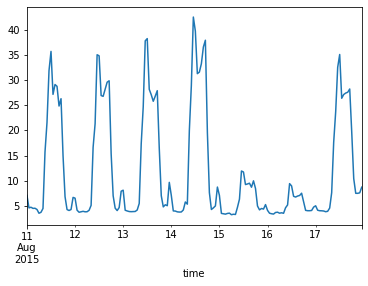

In [54]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4) / 4
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

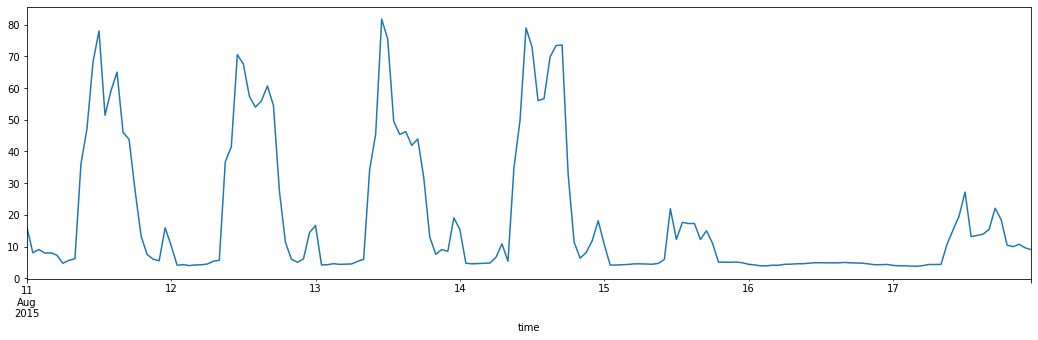

In [55]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [56]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [57]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [58]:
total_pred2 = data_total.loc[: "2015-08-17 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [59]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063462
0:	learn: 17.9541345	total: 2.91ms	remaining: 2.9s
1:	learn: 17.1668572	total: 5.54ms	remaining: 2.77s
2:	learn: 16.4419627	total: 8.28ms	remaining: 2.75s
3:	learn: 15.7720381	total: 10.9ms	remaining: 2.72s
4:	learn: 15.1575358	total: 13.4ms	remaining: 2.67s
5:	learn: 14.5964288	total: 15.9ms	remaining: 2.64s
6:	learn: 14.0740599	total: 18.4ms	remaining: 2.6s
7:	learn: 13.6070939	total: 20.8ms	remaining: 2.58s
8:	learn: 13.1636066	total: 23.4ms	remaining: 2.58s
9:	learn: 12.7600513	total: 25.9ms	remaining: 2.57s
10:	learn: 12.3902980	total: 28.5ms	remaining: 2.56s
11:	learn: 12.0467787	total: 32.6ms	remaining: 2.68s
12:	learn: 11.7297732	total: 35.1ms	remaining: 2.66s
13:	learn: 11.4498431	total: 37.5ms	remaining: 2.64s
14:	learn: 11.1953412	total: 39.9ms	remaining: 2.62s
15:	learn: 10.9662390	total: 42.3ms	remaining: 2.6s
16:	learn: 10.7478710	total: 44.8ms	remaining: 2.59s
17:	learn: 10.5461848	total: 47.3ms	remaining: 2.58s
18:	learn: 10.3652576	total: 

160:	learn: 5.9914366	total: 354ms	remaining: 1.84s
161:	learn: 5.9722238	total: 356ms	remaining: 1.84s
162:	learn: 5.9645133	total: 358ms	remaining: 1.84s
163:	learn: 5.9533993	total: 360ms	remaining: 1.84s
164:	learn: 5.9432924	total: 363ms	remaining: 1.83s
165:	learn: 5.9364711	total: 365ms	remaining: 1.83s
166:	learn: 5.9274089	total: 367ms	remaining: 1.83s
167:	learn: 5.9170521	total: 369ms	remaining: 1.83s
168:	learn: 5.9047575	total: 371ms	remaining: 1.83s
169:	learn: 5.8967634	total: 374ms	remaining: 1.82s
170:	learn: 5.8837689	total: 376ms	remaining: 1.82s
171:	learn: 5.8764073	total: 378ms	remaining: 1.82s
172:	learn: 5.8685295	total: 380ms	remaining: 1.82s
173:	learn: 5.8609182	total: 382ms	remaining: 1.81s
174:	learn: 5.8533551	total: 384ms	remaining: 1.81s
175:	learn: 5.8465078	total: 386ms	remaining: 1.81s
176:	learn: 5.8377399	total: 388ms	remaining: 1.8s
177:	learn: 5.8285305	total: 390ms	remaining: 1.8s
178:	learn: 5.8227283	total: 393ms	remaining: 1.8s
179:	learn: 5.8

330:	learn: 4.9407560	total: 715ms	remaining: 1.44s
331:	learn: 4.9376828	total: 717ms	remaining: 1.44s
332:	learn: 4.9339831	total: 719ms	remaining: 1.44s
333:	learn: 4.9317780	total: 721ms	remaining: 1.44s
334:	learn: 4.9277818	total: 723ms	remaining: 1.44s
335:	learn: 4.9233167	total: 725ms	remaining: 1.43s
336:	learn: 4.9185151	total: 727ms	remaining: 1.43s
337:	learn: 4.9155392	total: 730ms	remaining: 1.43s
338:	learn: 4.9131874	total: 732ms	remaining: 1.43s
339:	learn: 4.9107416	total: 734ms	remaining: 1.42s
340:	learn: 4.9055993	total: 736ms	remaining: 1.42s
341:	learn: 4.9025675	total: 738ms	remaining: 1.42s
342:	learn: 4.8987629	total: 740ms	remaining: 1.42s
343:	learn: 4.8963931	total: 742ms	remaining: 1.41s
344:	learn: 4.8942475	total: 744ms	remaining: 1.41s
345:	learn: 4.8900508	total: 746ms	remaining: 1.41s
346:	learn: 4.8844033	total: 748ms	remaining: 1.41s
347:	learn: 4.8808906	total: 750ms	remaining: 1.41s
348:	learn: 4.8760089	total: 752ms	remaining: 1.4s
349:	learn: 4

502:	learn: 4.3953913	total: 1.08s	remaining: 1.06s
503:	learn: 4.3923725	total: 1.08s	remaining: 1.06s
504:	learn: 4.3911120	total: 1.08s	remaining: 1.06s
505:	learn: 4.3885250	total: 1.08s	remaining: 1.06s
506:	learn: 4.3862247	total: 1.09s	remaining: 1.06s
507:	learn: 4.3841547	total: 1.09s	remaining: 1.05s
508:	learn: 4.3831376	total: 1.09s	remaining: 1.05s
509:	learn: 4.3814971	total: 1.09s	remaining: 1.05s
510:	learn: 4.3787628	total: 1.09s	remaining: 1.05s
511:	learn: 4.3773617	total: 1.1s	remaining: 1.04s
512:	learn: 4.3750644	total: 1.1s	remaining: 1.04s
513:	learn: 4.3720280	total: 1.1s	remaining: 1.04s
514:	learn: 4.3685475	total: 1.1s	remaining: 1.04s
515:	learn: 4.3668751	total: 1.1s	remaining: 1.04s
516:	learn: 4.3656159	total: 1.11s	remaining: 1.03s
517:	learn: 4.3627065	total: 1.11s	remaining: 1.03s
518:	learn: 4.3615848	total: 1.11s	remaining: 1.03s
519:	learn: 4.3600736	total: 1.11s	remaining: 1.03s
520:	learn: 4.3581661	total: 1.12s	remaining: 1.03s
521:	learn: 4.356

675:	learn: 4.0341155	total: 1.44s	remaining: 690ms
676:	learn: 4.0325522	total: 1.44s	remaining: 688ms
677:	learn: 4.0303667	total: 1.44s	remaining: 686ms
678:	learn: 4.0289973	total: 1.45s	remaining: 684ms
679:	learn: 4.0275099	total: 1.45s	remaining: 681ms
680:	learn: 4.0260814	total: 1.45s	remaining: 679ms
681:	learn: 4.0251837	total: 1.45s	remaining: 677ms
682:	learn: 4.0229816	total: 1.45s	remaining: 675ms
683:	learn: 4.0206726	total: 1.46s	remaining: 673ms
684:	learn: 4.0194164	total: 1.46s	remaining: 671ms
685:	learn: 4.0183971	total: 1.46s	remaining: 669ms
686:	learn: 4.0170613	total: 1.46s	remaining: 666ms
687:	learn: 4.0139445	total: 1.46s	remaining: 664ms
688:	learn: 4.0124935	total: 1.47s	remaining: 662ms
689:	learn: 4.0109499	total: 1.47s	remaining: 660ms
690:	learn: 4.0081618	total: 1.47s	remaining: 658ms
691:	learn: 4.0057670	total: 1.47s	remaining: 656ms
692:	learn: 4.0036245	total: 1.48s	remaining: 653ms
693:	learn: 4.0023124	total: 1.48s	remaining: 651ms
694:	learn: 

846:	learn: 3.7661931	total: 1.8s	remaining: 325ms
847:	learn: 3.7653602	total: 1.8s	remaining: 323ms
848:	learn: 3.7643613	total: 1.8s	remaining: 321ms
849:	learn: 3.7625986	total: 1.81s	remaining: 319ms
850:	learn: 3.7606267	total: 1.81s	remaining: 317ms
851:	learn: 3.7598496	total: 1.81s	remaining: 315ms
852:	learn: 3.7587602	total: 1.81s	remaining: 313ms
853:	learn: 3.7575388	total: 1.82s	remaining: 311ms
854:	learn: 3.7557246	total: 1.82s	remaining: 308ms
855:	learn: 3.7546010	total: 1.82s	remaining: 306ms
856:	learn: 3.7531149	total: 1.82s	remaining: 304ms
857:	learn: 3.7521542	total: 1.82s	remaining: 302ms
858:	learn: 3.7506169	total: 1.83s	remaining: 300ms
859:	learn: 3.7488786	total: 1.83s	remaining: 298ms
860:	learn: 3.7479627	total: 1.83s	remaining: 296ms
861:	learn: 3.7468610	total: 1.83s	remaining: 294ms
862:	learn: 3.7454153	total: 1.83s	remaining: 291ms
863:	learn: 3.7447483	total: 1.84s	remaining: 289ms
864:	learn: 3.7439533	total: 1.84s	remaining: 287ms
865:	learn: 3.7

<h5>构建xgboost</h5>

In [60]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[08:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [61]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [62]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:20:06,437 [INFO] loading LSTM model from ../models/LSTM_total_final.h5


In [63]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

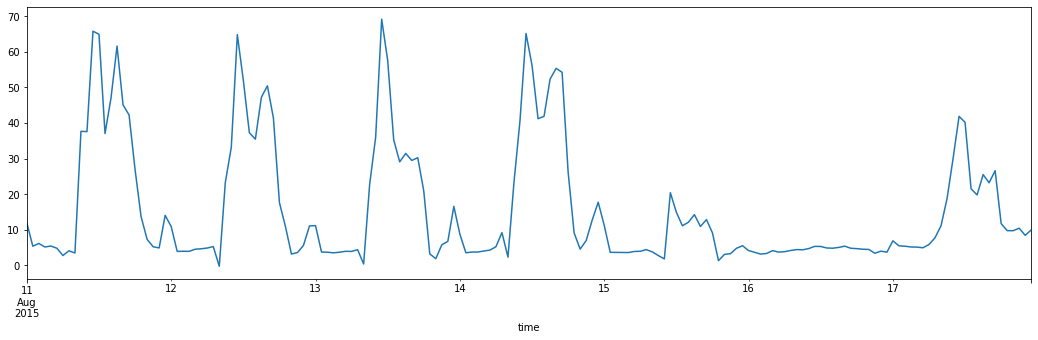

In [64]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4) / 4
total_pred[120:144] = total_pred2[120:144]

old_data = pd.read_csv("../data/submit_2023-04-26T10-59.csv")
delta = total_pred - old_data["total"].values
total_pred = total_pred + 2 * delta

data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [65]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,11.923499,0.780185,0.995319,7.099217
2015-08-11 01:00:00,5.409693,0.565047,0.431791,4.617763
2015-08-11 02:00:00,6.191917,0.596414,0.420086,4.741299
2015-08-11 03:00:00,5.196612,0.534110,0.379857,4.517027
2015-08-11 04:00:00,5.459289,0.560127,0.395044,4.540367
...,...,...,...,...
2015-08-17 19:00:00,9.778550,1.238140,3.579873,10.429389
2015-08-17 20:00:00,9.763694,1.033117,1.775990,7.510815
2015-08-17 21:00:00,10.467208,1.032493,1.331021,7.507400
2015-08-17 22:00:00,8.465421,0.969820,1.233292,7.609368


In [66]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)